# **ENPH 353 Plate Reader**
Once coordinates are found (assuming there are four corners in the image), the ML corner detector will pass the image along to this CNN. It will apply the inverse Perspective Transform and then Read the plate number and Location. 

In [7]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

import math
import numpy as np
import re
import os

from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image, ImageFont, ImageDraw

from IPython.display import display
from IPython.display import Image as _Imgdis
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#from keras.utils import np_utils
import cv2

from random import randint
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
import random

1.14.0


# Importing Plate Data as Numpy Array: 
Tutorial from https://www.kaggle.com/lgmoneda/from-image-files-to-numpy-arrays

In [8]:
#First part just gets the filenames and such ready:
folder = "./training_images"
onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
filenames = [] # the image filename 
labels = []     # the label

for _file in onlyfiles: # file names
    if _file.split('.')[1] == 'xml':
        filenames.append(_file)


# Only here do we start to atually take in images
border = 50 # Determines how close the image crop is
            # Larger should give more leeway. Changes Bounding Boxes! 
NOISE = 5   # pm pixel offset.

res_x = 300
res_y = int(res_x*1.5)

nb_classes = 1

dataset = np.ndarray(shape=(len(filenames), (res_y+border), (res_x+border)),
                     dtype=np.short) # this just makes the empty array.

Middle = 128.0

j = 0 # index of the output array 
# Here is where we must do the XML fun. 
for i in range(int(len(filenames))):
    location = folder + "/" + filenames[i]

    tree = ET.parse(location)
    root = tree.getroot()

    corners = 0
    for exists in root.iter('exists'):
        corners+= int(exists.text)
        
    if corners == 4: # applying cv2 transformations here, might get ugly
        topleft = (0,0)
        topright = (0,0)
        bottomleft = (0,0)
        bottomright = (0,0)
        
        for cord in root.findall('topleft'):
            topleft = (int(cord.find('xcoord').text), int(cord.find('ycoord').text))
        for cord in root.findall('topright'):
            topright = (int(cord.find('xcoord').text), int(cord.find('ycoord').text))
        for cord in root.findall('bottomleft'):
            bottomleft = (int(cord.find('xcoord').text), int(cord.find('ycoord').text))
        for cord in root.findall('bottomright'):
            bottomright = (int(cord.find('xcoord').text), int(cord.find('ycoord').text))

        pts1 = np.float32([[topleft[0],topleft[1]], 
                        [topright[0],topright[1]], 
                        [bottomleft[0],bottomleft[1]], 
                        [bottomright[0],bottomright[1]]]) #sorry
        
        pts2 = np.float32([[0,0], [res_x,0], [0,res_y], [res_x,res_y]])
        pts2 += int(border/2)
        
        with np.nditer(pts1, op_flags=['readwrite']) as it:
            for point in it:
                point += random.randint(-5,5) # Adding error to perspective transform to simulate innacuracy
        
        M = cv2.getPerspectiveTransform(pts1, pts2)
        
        location2 = '.' + location.split('.')[1] + '.png'
        im = cv2.imread(location2)
        
        dst = cv2.warpPerspective(im, M, (res_x+border,res_y+border))
       
        im_gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY) # wondering if some contrast would be nice here
#         im_gray = (im_gray - Middle) / Middle
        dataset[j] = im_gray    
        labels.append(filenames[i][5:16])
        
#         if j in range(0,15):
#             im = cv2.circle(im, (topleft[0],topleft[1]), 1, (0,0,255), 30)
#             im = cv2.circle(im, (topright[0],topright[1]), 1, (0,0,255), 30)
#             im = cv2.circle(im, (bottomleft[0],bottomleft[1]), 1, (0,0,255), 30)
#             im = cv2.circle(im, (bottomright[0],bottomright[1]), 1, (0,0,255), 30)
            
#             plt.figure()
#             plt.imshow(im) 
#             plt.show()
            
#             plt.figure()
#             plt.imshow(im_gray) 
#             plt.show()
            
        j += 1 

Length of 4 Cornered Images:  722
Dataset shape:  (722, 500, 350)


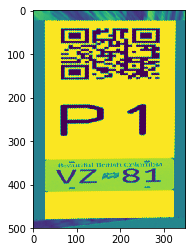

In [9]:
print("Length of 4 Cornered Images: ", len(labels))
dataset = dataset[0:len(labels)]
print("Dataset shape: ", dataset.shape)
plt.figure()
plt.imshow(dataset[2]) 
plt.show()

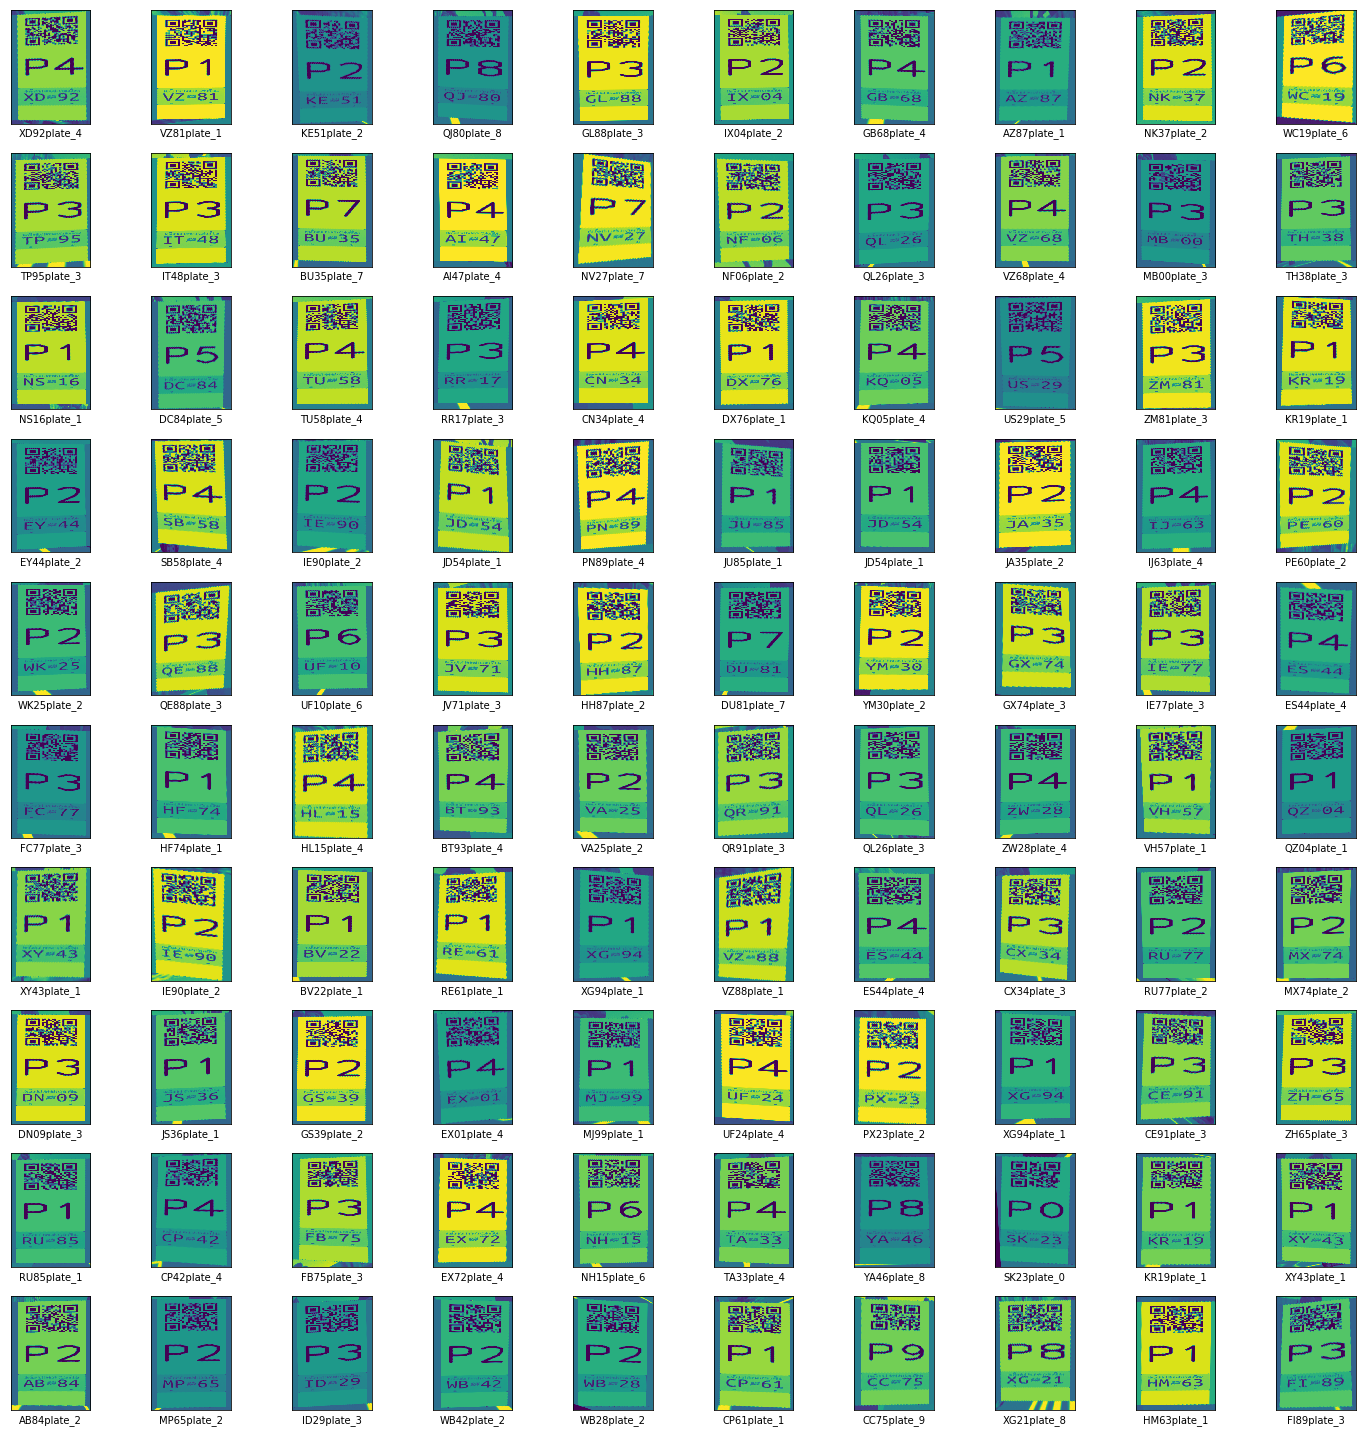

In [10]:
num_rows = 10 # i 
num_cols = 10 # 4 + 1

plt.figure(figsize=(2*num_cols, 2*num_rows))
for i in range(num_cols*num_rows):
    plt.subplot(num_rows, num_cols, i+1) # 1 indexing
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(dataset[i+1])
    plt.xlabel(labels[i+1])    
plt.tight_layout()
plt.show()

It works! We now a license plate with Labels 
# Split up the the indivudal characters. 
This is also where one would be translating the windows a bit and then adding this new dataset. 

Realized an obvious problem when translating the windows to cook some more data: if we have a translated testing image as a training image, this would be a clear problem. So, here we will split the data and THEN translate/duplicate windows

In [15]:
repeatdata = 1 # > 0 
randomness = 5 # 


def toint(char):
    if char.isalpha():
        return ord(char) - 55 # A is 10, B is 11, ... Can use chr(65) to invert
    else:
        return int(char)

def tochar(inty):
    inty = int(inty)
    if inty < 10:
        return str(inty)
    else:
        return chr(55+inty)
    
# def plate_to_chars(sublabel, subdataset, repeatdata):
pipe_x = 80
pipe_y = 80

setlen = len(labels)
letters = np.ndarray(shape=(setlen*repeatdata, 5, pipe_y, pipe_x),
                     dtype=np.float32)
print (letters.shape)
# this just makes the empty array for image files.

#First let's find the appropriate location for the letters:
plate1 = (340,40)
plate2 = (340,90)
plate3 = (335,180)
plate4 = (335,240)
location = (180,180)

def feature_image(featureloc, scale=1, pixoffset=0): #pixoffset >= 0
    Ypoint = featureloc[0]
    Xpoint = featureloc[1]
    if pixoffset != 0:
        Ypoint += random.randrange(-pixoffset,pixoffset,2)
        Xpoint += random.randrange(-pixoffset,pixoffset,2)

    Ydown   = slice(Ypoint,Ypoint+pipe_y*scale, scale)
    Xacross = slice(Xpoint,Xpoint+pipe_x*scale, scale)
    return dataset[:,Ydown,Xacross]

letters[:setlen,0] = feature_image(plate1)
letters[:setlen,1] = feature_image(plate2)
letters[:setlen,2] = feature_image(plate3)
letters[:setlen,3] = feature_image(plate4)
letters[:setlen,4] = feature_image(location, scale=2)

for i in range(1, repeatdata):
    b = i*setlen
    e = (i+1)*setlen
    letters[b:e,0] = feature_image(plate1, pixoffset=randomness)
    letters[b:e,1] = feature_image(plate2, pixoffset=randomness)
    letters[b:e,2] = feature_image(plate3, pixoffset=randomness)
    letters[b:e,3] = feature_image(plate4, pixoffset=randomness)
    letters[b:e,4] = feature_image(location, scale=2, pixoffset=randomness)

#The Labels. For ros translational simplicity, I want each index here to represent an image. 
#This will be flattened but for now it just makes morse sense
letterlabels = np.ndarray((setlen*repeatdata, 5), dtype=np.int8) 

i = 0
for label in labels:
    for j in range(repeatdata):
        up = j*setlen
        letterlabels[i+up,0] = toint(label[0])
        letterlabels[i+up,1] = toint(label[1])
        letterlabels[i+up,2] = toint(label[2])
        letterlabels[i+up,3] = toint(label[3])
        letterlabels[i+up,4] = toint(label[10])
    i += 1

(722, 5, 80, 80)


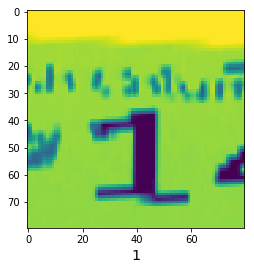

In [17]:
plt.figure()
plt.imshow(letters[300,2]) 
plt.xlabel(tochar(letterlabels[300,2]), fontsize='x-large')
plt.show()

Let's make a thing so we can look at how well we are doing with the cropping.
Thanks google: https://www.tensorflow.org/tutorials/keras/classification

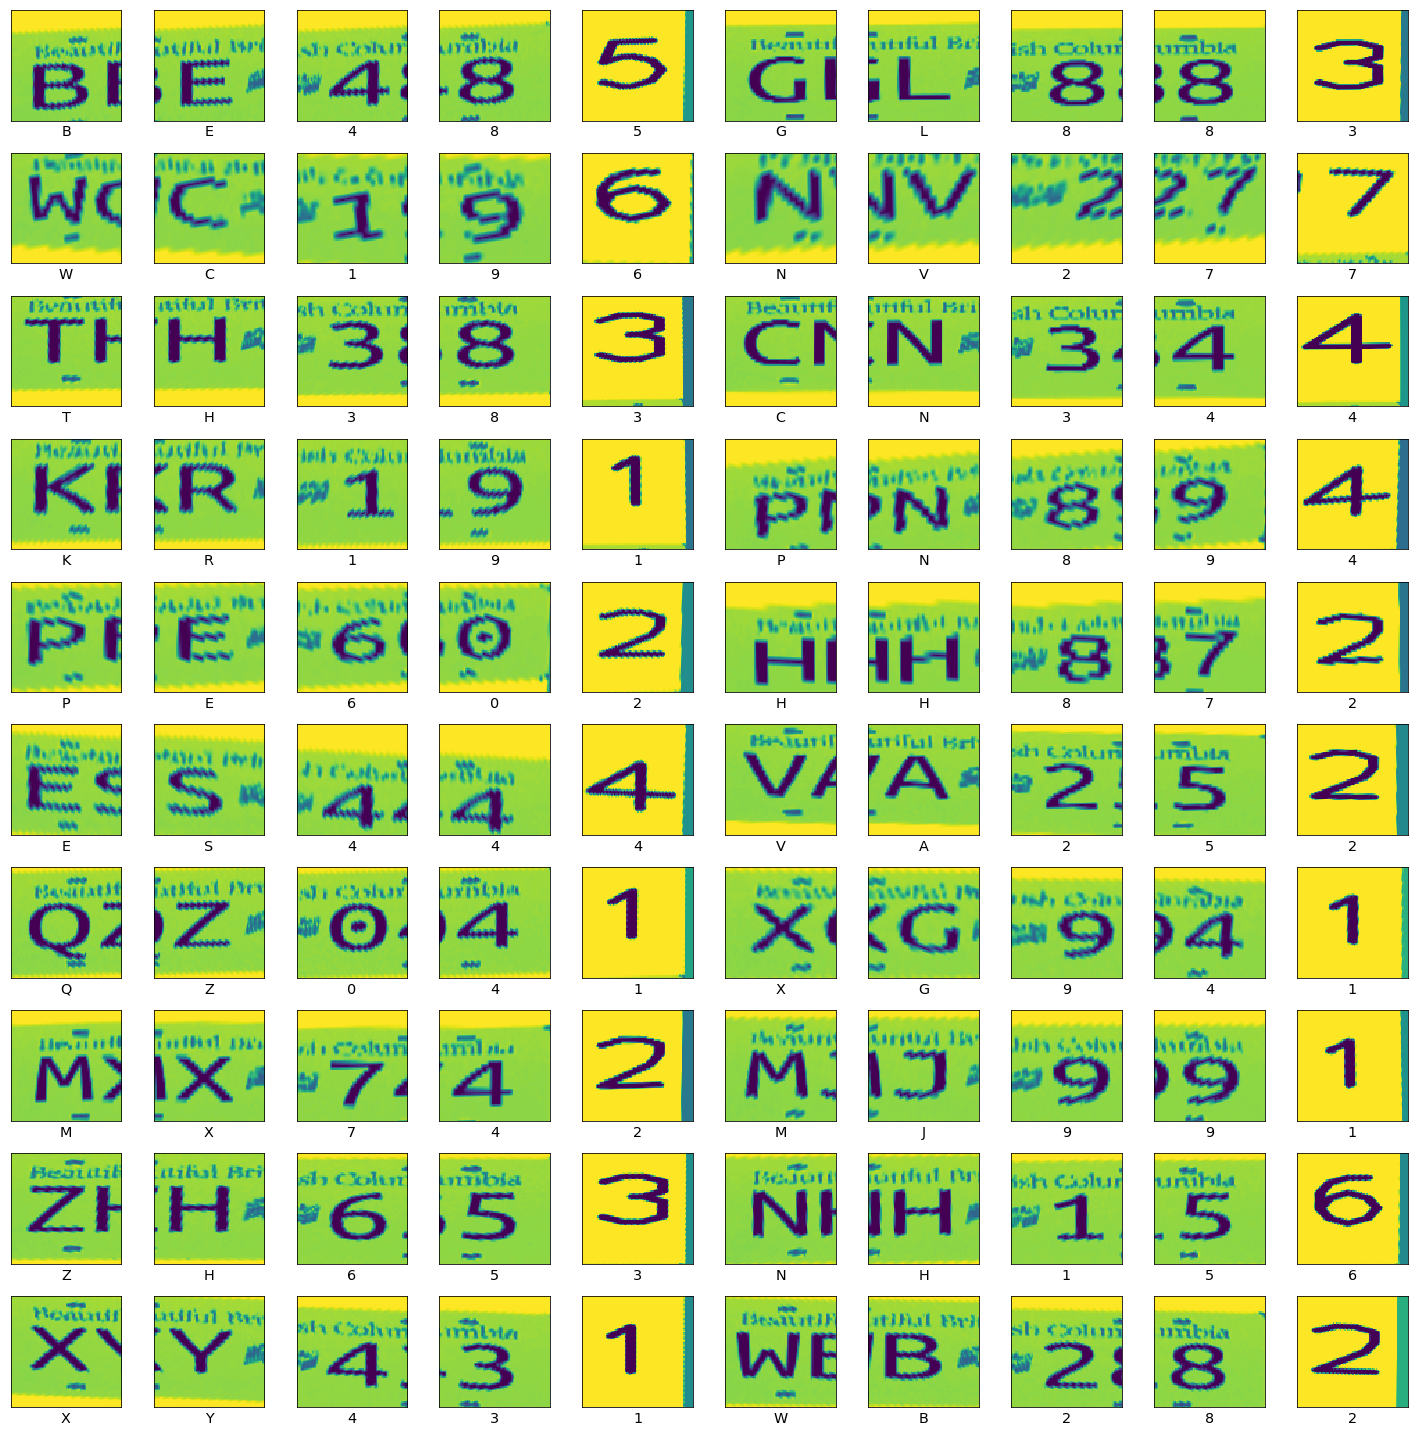

In [19]:
def plot_image(img, title):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img)
    #plt.title(tochar(title), fontsize='large')
    plt.xlabel(tochar(title), fontsize='x-large')

num_rows = 10 # i 
num_cols = 5 * 2 # multiple of 4 + 1 
startpoint = 0

plt.figure(figsize=(2*num_cols, 2*num_rows))
for i in range(0, num_rows*num_cols, 5):
    for j in range(5):
        plt.subplot(num_rows, num_cols, i+j+1) # 1 indexing
        plot_image(letters[i+startpoint,j], letterlabels[i+startpoint,j])
    
plt.tight_layout()
plt.show()


# Push into Keras CNN

(722, 5, 80, 80) -> (3610, 80, 80, 1)
(722, 5) -> (3610,)


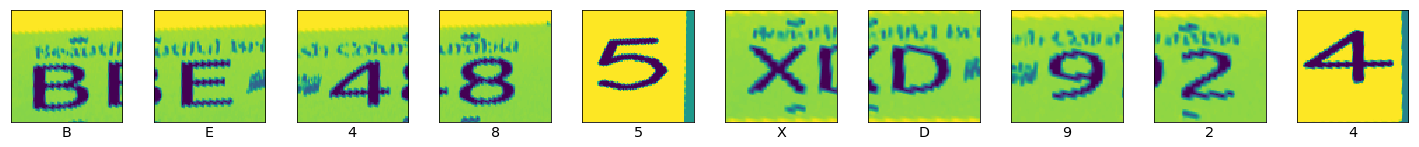

[11 14  4 ...  7  3  3]


In [20]:
letterline = np.reshape(letters, (-1,80,80,1))
labelline = np.ravel(letterlabels, order='C')

print (letters.shape, "->", letterline.shape)
print (letterlabels.shape, "->", labelline.shape)

#Ensure Order is Preserved:
num_rows = 1 # i 
num_cols = 5 * 2 # multiple of 4 + 1 
plt.figure(figsize=(2*num_cols, 2*num_rows))
for i in range(0, num_rows*num_cols):
    plt.subplot(num_rows, num_cols, i+1) # 1 indexing
    plot_image(letterline[i,:,:,0], labelline[i])
    
plt.tight_layout()
plt.show()

print(labelline)

In [21]:
# We don't want our mutated images to count for the 
x_train, x_test, y_train, y_test = train_test_split(letterline, labelline, test_size=0.33)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(80, 80, 1)))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(60, activation='relu'))
model.add(keras.layers.Dense(36, activation='softmax'))

model.summary()

(2418, 80, 80, 1) (2418,)
(1192, 80, 80, 1) (1192,)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 76, 76, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 36, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (M

In [22]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=7)

Epoch 1/7
2418/2418 [==============================] - 7s 3ms/sample - loss: 3.4924 - acc: 0.1199
Epoch 2/7
2418/2418 [==============================] - 8s 3ms/sample - loss: 2.5635 - acc: 0.3106
Epoch 3/7
2418/2418 [==============================] - 12s 5ms/sample - loss: 1.6428 - acc: 0.5083
Epoch 4/7
2418/2418 [==============================] - 14s 6ms/sample - loss: 0.9453 - acc: 0.6948
Epoch 5/7
2418/2418 [==============================] - 14s 6ms/sample - loss: 0.5394 - acc: 0.8275
Epoch 6/7
2418/2418 [==============================] - 13s 6ms/sample - loss: 0.3377 - acc: 0.8945
Epoch 7/7
2418/2418 [==============================] - 14s 6ms/sample - loss: 0.2768 - acc: 0.9189


In [23]:
#Below is predicted Data! 
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

print('\nTest accuracy:', test_acc)

predictions = model.predict(x_test)

1192/1192 - 2s - loss: 0.3748 - acc: 0.9002

Test accuracy: 0.90016776


In [25]:
#Saving Model: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
# serialize model to JSON
model_json = model.to_json()
with open("../model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("../model.h5")
print("Saved model to disk")

Saved model to disk


# Reincorporate into one Plate